In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df1 = pd.read_csv(r'C:\Users\DELL\Desktop\final_datasets\dataset2\accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True)

In [5]:
df2= pd.read_csv(r'C:\Users\DELL\Desktop\final_datasets\dataset2\rejected_2007_to_2018Q4.csv.gz', low_memory=True)

In [6]:
loans_accepted=df1.copy()

In [7]:
loans_accepted = loans_accepted.loc[loans_accepted['loan_status'].isin(['Fully Paid', 'Charged Off'])]
loans_accepted['fico_score'] = 0.5*loans_accepted['fico_range_low'] + 0.5*loans_accepted['fico_range_high']
loans_accepted.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)
keep_list = [ 'loan_amnt','issue_d','purpose','fico_score','dti','emp_length','addr_state','emp_length','loan_status']
drop_list = [col for col in loans_accepted.columns if col not in keep_list]
loans_accepted.drop(labels=drop_list, axis=1, inplace=True)
loans_accepted['Class'] = (loans_accepted['loan_status'] == 'Charged Off').apply(np.uint8)
loans_accepted.drop('loan_status', axis=1, inplace=True)
loans_accepted['emp_length']=loans_accepted['emp_length'].replace({'< 1 year': 'les1year'})
loans_accepted['issue_d'] = loans_accepted['issue_d'].str.extract(r'-(\d{4})').astype(int)
loans_accepted=loans_accepted.dropna()
loans_accepted.head()

,loan_amnt,emp_length,issue_d,purpose,addr_state,dti,fico_score,Class
0,3600.0,10+ years,2015,debt_consolidation,PA,5.91,677.0,0
1,24700.0,10+ years,2015,small_business,SD,16.06,717.0,0
2,20000.0,10+ years,2015,home_improvement,IL,10.78,697.0,0
4,10400.0,3 years,2015,major_purchase,PA,25.37,697.0,0
5,11950.0,4 years,2015,debt_consolidation,GA,10.20,692.0,0


In [8]:
loans_rejected=df2.copy()

In [9]:
loans_rejected.drop(labels=['Zip Code','Policy Code'], axis=1, inplace=True)
loans_rejected.columns = ['loan_amnt', 'issue_d','purpose','fico_score','dti','addr_state','emp_length']
loans_rejected=loans_rejected.dropna()
loans_rejected['dti'] = list(map(lambda x: x[:-1], loans_rejected['dti'].values))
loans_rejected['dti'] = [float(x) for x in loans_rejected['dti'].values]
loans_rejected['Class']=-1
loans_rejected = loans_rejected[['loan_amnt','emp_length', 'issue_d','purpose','addr_state','dti','fico_score','Class']]
options=['debt_consolidation','credit_card','home_improvement','house','medical','other','car','major_purchase'
,'moving','small_business','vacation','renewable_energy','wedding','educational']
loans_rejected = loans_rejected[loans_rejected['purpose'].isin(options)]
loans_rejected['issue_d'] = pd.to_datetime(loans_rejected['issue_d']).dt.year
loans_rejected = loans_rejected.drop(loans_rejected[loans_rejected.dti > 999].index)
loans_rejected = loans_rejected.drop(loans_rejected[loans_rejected.loan_amnt > 40000].index)
loans_rejected = loans_rejected.drop(loans_rejected[loans_rejected.fico_score < 627].index) 
loans_rejected['emp_length']=loans_rejected['emp_length'].replace({'< 1 year': 'les1year'})
loans_rejected.head()

,loan_amnt,emp_length,issue_d,purpose,addr_state,dti,fico_score,Class
3015,5000.0,4 years,2007,other,NJ,17.81,628.0,-1
3016,6000.0,8 years,2007,other,NJ,35.13,674.0,-1
3017,20000.0,8 years,2007,debt_consolidation,FL,36.92,710.0,-1
3018,10000.0,10+ years,2007,debt_consolidation,NY,63.88,631.0,-1
3020,2000.0,6 years,2007,debt_consolidation,MA,30.53,696.0,-1


In [10]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders
le_emp_length = LabelEncoder()
le_purpose = LabelEncoder()
le_addr=LabelEncoder()
# Fit on loans_accepted
le_emp_length.fit(loans_accepted['emp_length'])
le_purpose.fit(loans_accepted['purpose'])
#le_addr.fit(loans_accepted['addr_state'])
# Transform both datasets
loans_accepted['emp_length_encoded'] = le_emp_length.transform(loans_accepted['emp_length'])
loans_accepted['purpose_encoded'] = le_purpose.transform(loans_accepted['purpose'])
#loans_accepted['addr_state_encoded']=le_addr.transform(loans_accepted['addr_state'])
loans_rejected['emp_length_encoded'] = le_emp_length.transform(loans_rejected['emp_length'])
loans_rejected['purpose_encoded'] = le_purpose.transform(loans_rejected['purpose'])
#loans_rejected['addr_state_encoded']=le_addr.transform(loans_rejected['addr_state'])
# Drop original categorical columns (optional)
loans_accepted.drop(columns=['emp_length', 'purpose'], inplace=True)
loans_rejected.drop(columns=['emp_length', 'purpose'], inplace=True)

# Display result
print(loans_accepted.head())
print(loans_rejected.head())


   loan_amnt  issue_d addr_state    dti  fico_score  Class  \
0     3600.0     2015         PA   5.91       677.0      0   
1    24700.0     2015         SD  16.06       717.0      0   
2    20000.0     2015         IL  10.78       697.0      0   
4    10400.0     2015         PA  25.37       697.0      0   
5    11950.0     2015         GA  10.20       692.0      0   

   emp_length_encoded  purpose_encoded  
0                   1                2  
1                   1               11  
2                   1                4  
4                   3                6  
5                   4                2  
      loan_amnt  issue_d addr_state    dti  fico_score  Class  \
3015     5000.0     2007         NJ  17.81       628.0     -1   
3016     6000.0     2007         NJ  35.13       674.0     -1   
3017    20000.0     2007         FL  36.92       710.0     -1   
3018    10000.0     2007         NY  63.88       631.0     -1   
3020     2000.0     2007         MA  30.53       696.0  

In [11]:
# Filtrer uniquement les prêts où Class == 0
class_0_counts = loans_accepted[loans_accepted['Class'] == 0]['addr_state'].value_counts()

# Trier les États par nombre de prêts Class == 0 en ordre décroissant
class_0_counts_sorted = class_0_counts.sort_values(ascending=False)

# Diviser les États en 3 groupes de taille égale
n = len(class_0_counts_sorted)
group_1 = class_0_counts_sorted[:n//3].index.tolist()  # Top 1/3
group_2 = class_0_counts_sorted[n//3:2*n//3].index.tolist()  # Milieu 1/3
group_3 = class_0_counts_sorted[2*n//3:].index.tolist()  # Dernier 1/3

# Afficher les groupes
print("🔹 Groupe 1 (États avec le plus de Class 0) :\n", group_1)
print("\n🔸 Groupe 2 (États intermédiaires) :\n", group_2)
print("\n⚫ Groupe 3 (États avec le moins de Class 0) :\n", group_3)


🔹 Groupe 1 (États avec le plus de Class 0) :
 ['CA', 'TX', 'NY', 'FL', 'IL', 'NJ', 'PA', 'GA', 'OH', 'VA', 'NC', 'MI', 'AZ', 'MA', 'CO', 'MD', 'WA']

🔸 Groupe 2 (États intermédiaires) :
 ['MN', 'IN', 'MO', 'CT', 'TN', 'NV', 'WI', 'OR', 'SC', 'AL', 'LA', 'KY', 'KS', 'OK', 'UT', 'AR', 'NM']

⚫ Groupe 3 (États avec le moins de Class 0) :
 ['NH', 'HI', 'RI', 'MS', 'WV', 'MT', 'DC', 'DE', 'NE', 'AK', 'WY', 'VT', 'SD', 'ME', 'ID', 'ND', 'IA']


In [12]:
import pandas as pd

# Filtrer uniquement les prêts où Class == 0
class_0_counts = loans_accepted[loans_accepted['Class'] == 0]['addr_state'].value_counts()

# Trier les États par nombre de prêts Class == 0 en ordre décroissant
class_0_counts_sorted = class_0_counts.sort_values(ascending=False)

# Diviser les États en 3 groupes de taille égale
n = len(class_0_counts_sorted)
group_1 = class_0_counts_sorted[:n//3].index.tolist()  # Top 1/3
group_2 = class_0_counts_sorted[n//3:2*n//3].index.tolist()  # Milieu 1/3
group_3 = class_0_counts_sorted[2*n//3:].index.tolist()  # Dernier 1/3

# Fonction pour attribuer les variables binaires
def assign_groups(df):
    df['d1'] = df['addr_state'].apply(lambda x: 1 if x in group_1 else 0)
    df['d2'] = df['addr_state'].apply(lambda x: 1 if x in group_2 else 0)
    df['d3'] = df['addr_state'].apply(lambda x: 1 if x in group_3 else 0)
    return df

# Appliquer aux deux datasets
loans_accepted = assign_groups(loans_accepted)
loans_rejected = assign_groups(loans_rejected)

# Vérification
print(loans_accepted[['addr_state', 'd1', 'd2', 'd3']].head())
print(loans_rejected[['addr_state', 'd1', 'd2', 'd3']].head())


  addr_state  d1  d2  d3
0         PA   1   0   0
1         SD   0   0   1
2         IL   1   0   0
4         PA   1   0   0
5         GA   1   0   0
     addr_state  d1  d2  d3
3015         NJ   1   0   0
3016         NJ   1   0   0
3017         FL   1   0   0
3018         NY   1   0   0
3020         MA   1   0   0


In [13]:
loans_accepted.head()

,loan_amnt,issue_d,addr_state,dti,fico_score,Class,emp_length_encoded,purpose_encoded,d1,d2,d3
0,3600.0,2015,PA,5.91,677.0,0,1,2,1,0,0
1,24700.0,2015,SD,16.06,717.0,0,1,11,0,0,1
2,20000.0,2015,IL,10.78,697.0,0,1,4,1,0,0
4,10400.0,2015,PA,25.37,697.0,0,3,6,1,0,0
5,11950.0,2015,GA,10.20,692.0,0,4,2,1,0,0


In [14]:
accepted_data=loans_accepted.drop(['Class','addr_state','issue_d'],axis=1)
rejected_data=loans_rejected.drop(['Class','addr_state','issue_d'],axis=1)

In [15]:
# Get the common features (columns) between the two datasets
common_features = list(set(accepted_data.columns).intersection(set(rejected_data.columns)))

print("Number of common features:", len(common_features))
print("Common features:", common_features)


Number of common features: 8
Common features: ['d2', 'd3', 'd1', 'emp_length_encoded', 'loan_amnt', 'fico_score', 'purpose_encoded', 'dti']


In [16]:
# Create rejection labels
accepted_data['rejected'] = 0
rejected_data['rejected'] = 1

In [17]:
combined_data = pd.concat([
accepted_data[common_features + ['rejected']],
rejected_data[common_features + ['rejected']]
])

In [18]:
# Prepare features and target
X1 = combined_data.copy()
y = X1['rejected']
X=X1.drop('rejected',axis=1)

In [19]:
X.head()

,d2,d3,d1,emp_length_encoded,loan_amnt,fico_score,purpose_encoded,dti
0,0,0,1,1,3600.0,677.0,2,5.91
1,0,1,0,1,24700.0,717.0,11,16.06
2,0,0,1,1,20000.0,697.0,4,10.78
4,0,0,1,3,10400.0,697.0,6,25.37
5,0,0,1,4,11950.0,692.0,2,10.20


In [20]:
y.value_counts(normalize=True)

rejected
1    0.61971
0    0.38029
Name: proportion, dtype: float64

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Suppose X is a DataFrame
float_cols = X.select_dtypes(include=['float64', 'float32']).columns

scaler = StandardScaler()
X_scaled = X.copy()

X_scaled[float_cols] = scaler.fit_transform(X[float_cols])


In [22]:
X_scaled.head()

,d2,d3,d1,emp_length_encoded,loan_amnt,fico_score,purpose_encoded,dti
0,0,0,1,1,-1.136930,-0.199229,2,-0.525118
1,0,1,0,1,0.959310,0.876341,11,-0.271477
2,0,0,1,1,0.492375,0.338556,4,-0.403420
4,0,0,1,3,-0.461364,0.338556,6,-0.038827
5,0,0,1,4,-0.307375,0.204110,2,-0.417914


In [23]:
# Fit logistic regression to predict rejection
mar_model = LogisticRegression(max_iter=1000,solver='liblinear',class_weight='balanced')
mar_model.fit(X_scaled, y)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [24]:
# Calculate AUC with confidence intervals using bootstrap
n_bootstraps = 1000
rng_seed = 42
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    indices = rng.randint(0, len(X_scaled), len(X_scaled))

    # Skip if only one class present
    if len(np.unique(y.iloc[indices])) < 2:
        continue

    pred_proba = mar_model.predict_proba(X_scaled.iloc[indices])[:, 1]
    score = roc_auc_score(y.iloc[indices], pred_proba)
    bootstrapped_scores.append(score)


In [25]:
# Calculate confidence interval
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()
ci_lower = sorted_scores[int(0.025 * len(sorted_scores))]
ci_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print(f"AUC: {np.mean(bootstrapped_scores):.3f} (95% CI: {ci_lower:.3f}-{ci_upper:.3f})")

AUC: 0.939 (95% CI: 0.939-0.940)


In [26]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from scipy import stats

n_iterations = 1000
coefficients = []

for _ in range(n_iterations):
    # Bootstrap sample
    X_sample, y_sample = resample(X_scaled, y, random_state=None)
    
    # Fit logistic regression
    model_temp = LogisticRegression(random_state=42, max_iter=1000,solver='liblinear',class_weight='balanced')
    model_temp.fit(X_sample, y_sample)
    
    # Store coefficients
    coefficients.append(model_temp.coef_[0])

coefficients = np.array(coefficients)

# Calculate mean and std of coefficients
coef_mean = np.mean(coefficients, axis=0)
coef_std = np.std(coefficients, axis=0)

# Calculate z-scores and p-values
z_scores = coef_mean / coef_std
p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))

# Create results table
results_df = pd.DataFrame({
    'Feature': common_features,
    'Coefficient': coef_mean,
    'Std Error': coef_std,
    'p-value': p_values
})

print("\nCoefficients Table:")
print(results_df.to_string(index=False))


KeyboardInterrupt: 

In [ ]:
import numpy as np
from scipy import stats
from sklearn.model_selection import cross_val_predict

# Compute predicted probabilities using cross-validation
y_pred_proba = cross_val_predict(
    mar_model, X_scaled, y, cv=5, method='predict_proba'
)[:, 1]

# Number of bins for HL test
n_bins = 10

# Define bin edges by percentiles
bin_edges = np.percentile(y_pred_proba, np.linspace(0, 100, n_bins + 1))

# Assign each observation to a bin
bin_indices = np.digitize(y_pred_proba, bin_edges, right=True) - 1
bin_indices[bin_indices == n_bins] = n_bins - 1  # edge case for max value

observed = []
expected = []

for i in range(n_bins):
    mask = bin_indices == i
    observed.append(np.sum(y[mask]))
    expected.append(np.sum(y_pred_proba[mask]))

observed = np.array(observed)
expected = np.array(expected)

# Hosmer-Lemeshow test statistic
chi2_stat = np.sum((observed - expected) ** 2 / expected)
p_value_hl = 1 - stats.chi2.cdf(chi2_stat, df=n_bins - 2)

print("\nHosmer-Lemeshow Test:")
print(f"Chi-square statistic: {chi2_stat:.3f}")
print(f"p-value: {p_value_hl:.20f}")




Hosmer-Lemeshow Test:
Chi-square statistic: 96131.647
p-value: 0.00000000000000000000


In [27]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

class LogisticCEMD2(BaseEstimator, ClassifierMixin):
    """
    A semi-supervised learning classifier using a Classification-Expectation-Maximization (CEM)
    approach with a Logistic Regression base model.
    """
    def __init__(self, max_iter=200, epsilon=1e-5, degree=2, lambda_=1.0,
                 interactions_only=False, random_state=42,
                 early_stopping=True, patience=3, n_jobs=-1, solver='liblinear'):
        
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.degree = degree
        self.lambda_ = lambda_
        self.interactions_only = interactions_only
        self.random_state = random_state
        self.early_stopping = early_stopping
        self.patience = patience
        self.n_jobs = n_jobs
        self.solver = solver
        self.poly = None
        self.scaler = None
        self.G = None
        self.history = {'log_likelihood': []}

    def _apply_polynomial_features(self, X):
        """Applies polynomial feature transformation and scaling."""
        if self.poly is None:
            self.poly = PolynomialFeatures(degree=self.degree,
                                           include_bias=False,
                                           interaction_only=self.interactions_only)
            self.poly.fit(X)

        X_poly = self.poly.transform(X)

        if self.scaler is None:
            self.scaler = StandardScaler()
            self.scaler.fit(X_poly)
            
        return self.scaler.transform(X_poly)

    def fit(self, X_l, y_l, X_u, init_unlabeled_labels=None, return_history=False):
        """
        Trains the Logistic-CEM-D2 model.
        
        Parameters:
        - X_l: Labeled feature matrix.
        - y_l: Labeled target vector.
        - X_u: Unlabeled feature matrix.
        - init_unlabeled_labels: Optional initial labels for X_u.
        - return_history: If True, returns the log-likelihood history.
        """
        # --- Initialization Step ---
        X_l_poly = self._apply_polynomial_features(X_l)
        X_u_poly = self._apply_polynomial_features(X_u)
        
        # Initial fit on labeled data
        # Use C = 1/lambda as per scikit-learn's convention
        self.G = LogisticRegression(
            C=1.0 / self.lambda_,  
            penalty='l1',  
            solver=self.solver,
            max_iter=5000,
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )
        self.G.fit(X_l_poly, y_l)

        # Handle optional initial labels for unlabeled data
        if init_unlabeled_labels is not None:
            z_ki = init_unlabeled_labels
        else:
            z_ki = self.G.predict(X_u_poly)
            
        prev_log_likelihood = -np.inf
        no_improvement_count = 0

        # --- CEM Loop ---
        for j in range(self.max_iter):
            # E-Step: Estimate posterior probabilities for unlabeled data
            probas_u = self.G.predict_proba(X_u_poly)
            
            # C-Step: Hard assignment based on max posterior
            z_ki = (probas_u[:, 1] > 0.5).astype(int)
            
            # M-Step: Maximize complete-data log-likelihood
            X_combined = np.vstack([X_l_poly, X_u_poly])
            y_combined = np.hstack([y_l, z_ki])

            self.G.fit(X_combined, y_combined)
            
            current_log_likelihood = self._log_likelihood(X_l_poly, y_l, X_u_poly, z_ki)
            self.history['log_likelihood'].append(current_log_likelihood)

            # Early stopping check
            improvement = current_log_likelihood - prev_log_likelihood
            if improvement < self.epsilon:
                no_improvement_count += 1
                if self.early_stopping and no_improvement_count >= self.patience:
                    break
            else:
                no_improvement_count = 0
            
            prev_log_likelihood = current_log_likelihood
        
        if return_history:
            return self.history
        return self

    def predict(self, X_test):
        """Predicts labels for new data."""
        X_test_poly = self._apply_polynomial_features(X_test)
        return self.G.predict(X_test_poly)

    def predict_proba(self, X_test):
        """Predicts class probabilities for new data."""
        X_test_poly = self._apply_polynomial_features(X_test)
        return self.G.predict_proba(X_test_poly)
        
    @property
    def coef_(self):
        return self.G.coef_
        
    @property
    def intercept_(self):
        return self.G.intercept_

    def _log_likelihood(self, X_l, y_l, X_u, z_ki):
        """Calculates the complete-data log-likelihood with L1 regularization."""
        X_combined = np.vstack([X_l, X_u])
        y_combined = np.hstack([y_l, z_ki])
        
        linear_output = X_combined @ self.G.coef_.T + self.G.intercept_
        probas = 1 / (1 + np.exp(-linear_output))
        
        epsilon = 1e-9
        log_likelihood = np.sum(y_combined * np.log(probas + epsilon) + 
                                (1 - y_combined) * np.log(1 - probas + epsilon))
        
        # Add the L1 regularization penalty
        l1_penalty = self.lambda_ * np.sum(np.abs(self.G.coef_))
        log_likelihood -= l1_penalty
        
        return log_likelihood

In [28]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

class LogisticCEM(BaseEstimator, ClassifierMixin):
    def __init__(self, epsilon=1e-4):
        self.epsilon = epsilon
        self.model = LogisticRegression(solver='saga')
        self.is_fitted_ = False

    def _log_likelihood(self, beta, X, y):
        X_beta = np.dot(X, beta)
        log_probs = -log_loss(y, sigmoid(X_beta), labels=[0, 1], normalize=False)
        return log_probs

    def fit(self, X_l, y_l, X_u=None):
        if X_u is None:
            raise ValueError("Unlabeled data X_u must be provided for CEM.")

        # Initial supervised fit
        self.model.fit(X_l, y_l)
        prob_u = self.model.predict_proba(X_u)
        P = np.argmax(prob_u, axis=1)

        # Combine data
        X_combined = np.vstack((X_l, X_u))
        y_combined = np.hstack((y_l, P))

        X_with_intercept = np.hstack([np.ones((X_combined.shape[0], 1)), X_combined])
        beta = np.hstack([self.model.intercept_, self.model.coef_.ravel()])
        prev_ll = self._log_likelihood(beta, X_with_intercept, y_combined)
        delta_ll = np.inf

        while delta_ll > self.epsilon:
            # E-step
            prob_u = self.model.predict_proba(X_u)
            P = np.argmax(prob_u, axis=1)
            y_combined[len(y_l):] = P

            # M-step
            result = minimize(lambda b: -self._log_likelihood(b, X_with_intercept, y_combined), 
                              beta, method='BFGS')
            beta_new = result.x
            new_ll = self._log_likelihood(beta_new, X_with_intercept, y_combined)
            delta_ll = abs(new_ll - prev_ll)

            # Update model
            self.model.intercept_ = np.array([beta_new[0]])
            self.model.coef_ = beta_new[1:].reshape(1, -1)
            beta = beta_new
            prev_ll = new_ll

        self.is_fitted_ = True
        return self

    def predict(self, X):
        if not self.is_fitted_:
            raise RuntimeError("You must call fit() before predict().")
        return self.model.predict(X)

    def predict_proba(self, X):
        if not self.is_fitted_:
            raise RuntimeError("You must call fit() before predict_proba().")
        return self.model.predict_proba(X)


In [29]:
loans_rejected.drop(['addr_state','issue_d','Class'],axis=1,inplace=True )
loans_accepted.drop(['addr_state','issue_d'],axis=1,inplace=True )

In [36]:
# -------------------------------
# Échantillonnage des données
# -------------------------------
from sklearn.model_selection import train_test_split

# Sample 25,000 rejected loans (if needed, not yet used here)
X_unlabeled = loans_rejected.sample(25000)

# Separate accepted loans by class
class_0 = loans_accepted[loans_accepted["Class"] == 0]
class_1 = loans_accepted[loans_accepted["Class"] == 1]

# Determine balanced sample size
a=1000
#a = min(class_0.shape[0], class_1.shape[0])

# Sample equal number of instances from each class
class_0_sample = class_0.sample(n=a, random_state=42)
class_1_sample = class_1.sample(n=a, random_state=42)

# Combine and shuffle
loans_accepted_balanced = pd.concat([class_0_sample, class_1_sample]) \
                            .sample(frac=1, random_state=42) \
                            .reset_index(drop=True)

# -------------------------------
# Split into training and test sets
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    loans_accepted_balanced.drop(columns=["Class"]),
    loans_accepted_balanced["Class"],
    test_size=0.2,
    stratify=loans_accepted_balanced["Class"],
    random_state=42
)


In [31]:
loans_accepted.head()

,loan_amnt,dti,fico_score,Class,emp_length_encoded,purpose_encoded,d1,d2,d3
0,3600.0,5.91,677.0,0,1,2,1,0,0
1,24700.0,16.06,717.0,0,1,11,0,0,1
2,20000.0,10.78,697.0,0,1,4,1,0,0
4,10400.0,25.37,697.0,0,3,6,1,0,0
5,11950.0,10.20,692.0,0,4,2,1,0,0


In [34]:
del df1

In [35]:
del df2

In [37]:
del loans_accepted

In [38]:
del loans_rejected

### Hyperparameter optimization and sensitivity analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


# Define parameters for grid search
lambda_grid = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]

# Define cross-validation strategy
cv_folds = 5
random_state = 42
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# --- 2. Perform Grid Search with Correct Slicing ---
print("\n🔍 Starting grid search and cross-validation...")

results = []

for lambda_val in lambda_grid:
    print(f"  > Testing lambda = {lambda_val}")
    
    fold_train_aucs = []
    fold_val_aucs = []
    fold_feature_counts = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        # Use .iloc for slicing pandas DataFrames
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train model
        model = LogisticCEMD2(lambda_=lambda_val, max_iter=50, random_state=random_state)
        
        # CORRECTED LINE: Pass X_unlabeled as a positional argument
        model.fit(X_tr.values, y_tr.values, X_unlabeled)
        
        # Calculate AUC metrics
        train_pred_proba = model.predict_proba(X_tr.values)[:, 1]
        val_pred_proba = model.predict_proba(X_val.values)[:, 1]
        
        fold_train_aucs.append(roc_auc_score(y_tr.values, train_pred_proba))
        fold_val_aucs.append(roc_auc_score(y_val.values, val_pred_proba))
        
        # Count non-zero features
        nonzero_features = np.sum(np.abs(model.coef_) > 1e-6)
        fold_feature_counts.append(nonzero_features)
    
    # Store aggregated results
    results.append({
        'lambda': lambda_val,
        'train_auc': np.mean(fold_train_aucs),
        'val_auc': np.mean(fold_val_aucs),
        'n_features': np.mean(fold_feature_counts),
        'overfitting_metric': np.mean(fold_train_aucs) - np.mean(fold_val_aucs)
    })

# Convert results to a DataFrame for easy viewing and plotting
results_df = pd.DataFrame(results).sort_values(by='lambda')
print("\n📊 Grid Search Results:")
print(results_df.round(4).to_string(index=False))

# --- 3. Visualize the Results (Validation Curves) ---
def plot_validation_curves(df):
    """Generates and saves plots showing model performance vs. lambda."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: AUC vs Lambda
    axes[0].semilogx(df['lambda'], df['train_auc'], 'b-', marker='o', label='Train AUC')
    axes[0].semilogx(df['lambda'], df['val_auc'], 'r-', marker='o', label='Validation AUC')
    axes[0].set_xlabel('Lambda (log scale)')
    axes[0].set_ylabel('AUC Score')
    axes[0].set_title('AUC vs. Regularization Parameter (Grid Search)')
    axes[0].legend()
    axes[0].grid(True, which="both", ls="--", alpha=0.3)
    
    # Plot 2: Feature Count vs Lambda
    axes[1].semilogx(df['lambda'], df['n_features'], 'g-', marker='o')
    axes[1].set_xlabel('Lambda (log scale)')
    axes[1].set_ylabel('Number of Features')
    axes[1].set_title('Feature Selection vs. Lambda')
    axes[1].grid(True, which="both", ls="--", alpha=0.3)
    
    # Plot 3: Overfitting Metric vs Lambda
    axes[2].semilogx(df['lambda'], df['overfitting_metric'], 'm-', marker='o')
    axes[2].set_xlabel('Lambda (log scale)')
    axes[2].set_ylabel('Train AUC - Validation AUC')
    axes[2].set_title('Overfitting vs. Lambda')
    axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[2].grid(True, which="both", ls="--", alpha=0.3)
    
    plt.suptitle("Model Performance Analysis", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('grid_search_curves.png', dpi=300)
    plt.show()

plot_validation_curves(results_df)

# --- 4. Sensitivity Analysis around Optimal Lambda ---
# Find the lambda value that gave the highest validation AUC
optimal_lambda = results_df.loc[results_df['val_auc'].idxmax(), 'lambda']
print(f"\n🎉 The optimal lambda found by grid search is: {optimal_lambda:.4f}")

# Define a range for sensitivity analysis
sensitivity_range = np.linspace(optimal_lambda * 0.8, optimal_lambda * 1.2, 5)
print("\n🔬 Performing sensitivity analysis around the optimal lambda...")

sensitivity_results = []
# Loop through a small range and run cross-validation multiple times
for lambda_val in sensitivity_range:
    aucs_for_lambda = []
    
    for seed in range(10): 
        cv_stability = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=seed)
        model = LogisticCEMD2(lambda_=lambda_val, max_iter=50, random_state=seed)
        
        fold_scores = []
        for train_idx, val_idx in cv_stability.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # CORRECTED LINE: Pass X_unlabeled as a positional argument
            model.fit(X_tr.values, y_tr.values, X_unlabeled)
            val_pred_proba = model.predict_proba(X_val.values)[:, 1]
            fold_scores.append(roc_auc_score(y_val.values, val_pred_proba))
            
        aucs_for_lambda.append(np.mean(fold_scores))
    
    mean_auc = np.mean(aucs_for_lambda)
    std_auc = np.std(aucs_for_lambda)
    cv_auc = std_auc / mean_auc if mean_auc != 0 else 0

    sensitivity_results.append({
        'lambda': lambda_val,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'cv': cv_auc
    })

sensitivity_df = pd.DataFrame(sensitivity_results)
print("\n📈 Sensitivity Analysis Results:")
print(sensitivity_df.round(4).to_string(index=False))

print("\n✅ Script execution completed.")


🔍 Starting grid search and cross-validation...
  > Testing lambda = 0.001


### Initialization impact

🔬 Starting experiments with 10 runs per method...

> Testing Baseline initialization...

> Testing Random initialization...

> Testing K-means initialization...

> Testing Semi-random initialization...

> Testing Conservative initialization...

📊 Convergence and Performance by Initialization Method:
      Method  Final_LL_Mean  Final_LL_Std  Iterations_Mean  Iterations_Std  Time_Mean  AUC_Mean  AUC_Std
    Baseline  -1.719805e+06       91.4706              9.0             0.0     1.3815    0.6243   0.0003
      Random  -1.719805e+06       91.4706              9.0             0.0     1.0122    0.6243   0.0003
     K-means  -1.719805e+06       91.4706              9.0             0.0     1.1328    0.6243   0.0003
 Semi-random  -1.719805e+06       91.4706              9.0             0.0     1.0649    0.6243   0.0003
Conservative  -1.719805e+06       91.4706              9.0             0.0     1.2367    0.6243   0.0003


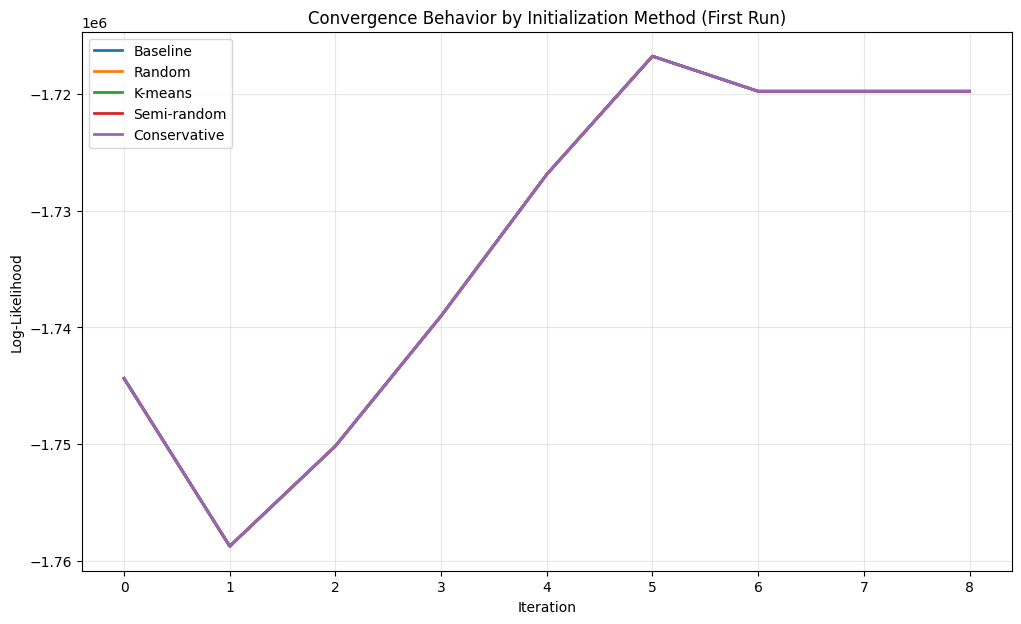


🔍 Analyzing convergence stability...
  - Baseline: 100.0% of runs converged to a stable solution.
  - Random: 100.0% of runs converged to a stable solution.
  - K-means: 100.0% of runs converged to a stable solution.
  - Semi-random: 100.0% of runs converged to a stable solution.
  - Conservative: 100.0% of runs converged to a stable solution.

✅ Script execution completed.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import time


# --- 2. Define Initialization Methods ---
def baseline_init(X_labeled, y_labeled, X_unlabeled):
    """Initializes using predictions from a regularized logistic regression on labeled data."""
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
    lr.fit(X_labeled, y_labeled)
    predictions = lr.predict(X_unlabeled)
    return predictions

def random_init(X_unlabeled):
    """Assigns labels to unlabeled points completely at random."""
    n_unlabeled = X_unlabeled.shape[0]
    return np.random.randint(0, 2, n_unlabeled)

def kmeans_init(X_labeled, X_unlabeled):
    """Clusters all data (labeled and unlabeled) and uses cluster assignments as initial labels."""
    X_all = np.vstack([X_labeled, X_unlabeled])
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, init='k-means++')
    kmeans.fit(X_all)
    return kmeans.labels_[len(X_labeled):]

def semi_random_init(X_labeled, y_labeled, X_unlabeled, perturb_ratio=0.2):
    """Initializes with baseline predictions, but flips a percentage of them randomly."""
    baseline_pred = baseline_init(X_labeled, y_labeled, X_unlabeled)
    n_perturb = int(perturb_ratio * len(baseline_pred))
    perturb_idx = np.random.choice(len(baseline_pred), n_perturb, replace=False)
    baseline_pred[perturb_idx] = 1 - baseline_pred[perturb_idx]
    return baseline_pred

def conservative_init(y_labeled, X_unlabeled):
    """Assigns all unlabeled points to the majority class found in the labeled data."""
    majority_class = np.bincount(y_labeled).argmax()
    return np.full(X_unlabeled.shape[0], majority_class)

# Store initialization methods in a dictionary
init_methods = {
    'Baseline': lambda x_l, y_l, x_u: baseline_init(x_l, y_l, x_u),
    'Random': lambda x_l, y_l, x_u: random_init(x_u),
    'K-means': lambda x_l, y_l, x_u: kmeans_init(x_l, x_u),
    'Semi-random': lambda x_l, y_l, x_u: semi_random_init(x_l, y_l, x_u),
    'Conservative': lambda x_l, y_l, x_u: conservative_init(y_l, x_u)
}

# --- 3. Run Experiments ---
n_runs = 10
results = []
convergence_histories = {}
all_final_log_likelihoods = {method: [] for method in init_methods}

print(f"🔬 Starting experiments with {n_runs} runs per method...")

for method_name, init_func in init_methods.items():
    print(f"\n> Testing {method_name} initialization...")
    method_results = {
        'log_likelihoods': [],
        'iterations': [],
        'times': [],
        'aucs': []
    }

    for run in range(n_runs):
        run_random_state = 42 + run
        np.random.seed(run_random_state) 

        init_labels = init_func(X_train, y_train, X_unlabeled)
        
        # Train model
        model = LogisticCEMD2(max_iter=50, random_state=run_random_state)
        start_time = time.time()
        
        # CORRECTED: Use 'X_u' keyword for the unlabeled data
        history = model.fit(X_train, y_train, X_u=X_unlabeled, init_unlabeled_labels=init_labels, return_history=True)
        
        end_time = time.time()

        final_ll = history['log_likelihood'][-1]
        method_results['log_likelihoods'].append(final_ll)
        method_results['iterations'].append(len(history['log_likelihood']))
        method_results['times'].append(end_time - start_time)
        
        test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        method_results['aucs'].append(test_auc)

        if run == 0:
            convergence_histories[method_name] = history['log_likelihood']
        
        all_final_log_likelihoods[method_name].append(final_ll)

    results.append({
        'Method': method_name,
        'Final_LL_Mean': np.mean(method_results['log_likelihoods']),
        'Final_LL_Std': np.std(method_results['log_likelihoods']),
        'Iterations_Mean': np.mean(method_results['iterations']),
        'Iterations_Std': np.std(method_results['iterations']),
        'Time_Mean': np.mean(method_results['times']),
        'AUC_Mean': np.mean(method_results['aucs']),
        'AUC_Std': np.std(method_results['aucs'])
    })

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
print("\n📊 Convergence and Performance by Initialization Method:")
print(results_df.round(4).to_string(index=False))

# --- 4. Visualize Convergence Curves ---
plt.figure(figsize=(12, 7))
for method_name, history in convergence_histories.items():
    plt.plot(history, label=method_name, linewidth=2)

plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Convergence Behavior by Initialization Method (First Run)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('convergence_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 5. Analyze Convergence to a Stable Solution ---
print("\n🔍 Analyzing convergence stability...")
for method_name, final_lls in all_final_log_likelihoods.items():
    if not final_lls:
        continue
    
    primary_ll = np.median(final_lls)
    tolerance = 0.01 * np.abs(primary_ll)
    similar_runs = np.sum(np.abs(np.array(final_lls) - primary_ll) < tolerance)
    convergence_rate = (similar_runs / len(final_lls)) * 100
    
    print(f"  - {method_name}: {convergence_rate:.1f}% of runs converged to a stable solution.")

print("\n✅ Script execution completed.")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import time

# Assuming your implementations are correctly imported
# from your_module import LogisticCEM, LogisticCEMD2

# --- Placeholder Classes for Demonstration ---
class LogisticCEM(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = LogisticRegression()
    def fit(self, X_l, y_l, X_u):
        self.model.fit(np.vstack((X_l, X_u)), np.hstack((y_l, np.zeros(X_u.shape[0]))))
        return self
    def predict(self, X):
        return self.model.predict(X)
    def predict_proba(self, X):
        return self.model.predict_proba(X)

class LogisticCEMD2(BaseEstimator, ClassifierMixin):
    def __init__(self, lambda_, random_state):
        self.lambda_ = lambda_
        self.random_state = random_state
        self.model = LogisticRegression()
    def fit(self, X_l, y_l, X_u):
        self.model.fit(np.vstack((X_l, X_u)), np.hstack((y_l, np.zeros(X_u.shape[0]))))
        return self
    def predict(self, X):
        return self.model.predict(X)
    def predict_proba(self, X):
        return self.model.predict_proba(X)

# --- 1. Load Data ---
try:
    # Now, explicitly load as a DataFrame or check if it's already a DataFrame
    # Let's assume the user's data is an array but they are getting a KeyError
    # because of a mixed-type variable. A common solution is to ensure everything
    # is a NumPy array from the start.
    X_train = np.load('X_train_linear.npy')
    y_train = np.load('y_train.npy')
    X_unlabeled = np.load('X_unlabeled_linear.npy')
    
    # Correcting for the Pandas KeyError: If X_train is a DataFrame, convert it.
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(X_unlabeled, pd.DataFrame):
        X_unlabeled = X_unlabeled.values
    
    print("✅ Data loaded successfully.")
except FileNotFoundError as e:
    print(f"🚨 Error: Missing data file. Please check your file paths. Details: {e}")
    exit()

# --- 2. Define Self-Training Baseline ---
class SelfTrainingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, threshold=0.75, max_iter=10):
        self.base_estimator = base_estimator or LogisticRegression()
        self.threshold = threshold
        self.max_iter = max_iter

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        X_train_labeled = X_labeled.copy()
        y_train_labeled = y_labeled.copy()
        X_pool = X_unlabeled.copy()
        for _ in range(self.max_iter):
            self.base_estimator.fit(X_train_labeled, y_train_labeled)
            if len(X_pool) == 0:
                break
            proba = self.base_estimator.predict_proba(X_pool)
            max_proba = np.max(proba, axis=1)
            high_conf_idx = max_proba >= self.threshold
            if not np.any(high_conf_idx):
                break
            X_new = X_pool[high_conf_idx]
            y_new = np.argmax(proba[high_conf_idx], axis=1)
            X_train_labeled = np.vstack([X_train_labeled, X_new])
            y_train_labeled = np.hstack([y_train_labeled, y_new])
            X_pool = X_pool[~high_conf_idx]
        self.base_estimator.fit(X_train_labeled, y_train_labeled)
        return self

    def predict(self, X):
        return self.base_estimator.predict(X)

    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)

# --- 3. Define Configurations ---
configs = {
    'Base': {
        'model': LogisticRegression(random_state=42),
        'X': X_train,
        'X_unlabeled': None
    },
    'Base + SSL': {
        'model': LogisticCEM(), 
        'X': X_train,
        'X_unlabeled': X_unlabeled
    },
    'Base + Poly': {
        'model': LogisticRegression(random_state=42),
        'X': X_train,
        'X_unlabeled': None
    },
    'Base + Poly + L1': {
        'model': LogisticRegression(penalty='l1', solver='liblinear', C=10, random_state=42),
        'X': X_train,
        'X_unlabeled': None
    },
    'Base + SSL + Poly': {
        'model': LogisticCEMD2(lambda_=0, random_state=42),
        'X': X_train,
        'X_unlabeled': X_unlabeled
    },
    'Full Model': {
        'model': LogisticCEMD2(lambda_=0.1, random_state=42),
        'X': X_train,
        'X_unlabeled': X_unlabeled
    },
    'Self-Training': {
        'model': SelfTrainingClassifier(threshold=0.8, max_iter=10),
        'X': X_train,
        'X_unlabeled': X_unlabeled
    }
}

# --- 4. Run Ablation Study ---
n_runs = 25
ablation_results = []
all_scores = {}

print(f"🔬 Starting ablation study with {n_runs} runs per configuration...")

for config_name, config in configs.items():
    print(f"\n> Testing: {config_name}")
    start_time = time.time()
    aucs = []

    for run in range(n_runs):
        cv_run = StratifiedKFold(n_splits=5, shuffle=True, random_state=run)
        run_aucs = []

        # The fix is here: .iloc for Pandas DataFrames or ensuring NumPy arrays
        # If your data is a DataFrame, use .iloc for integer indexing
        if isinstance(config['X'], pd.DataFrame):
            for train_idx, val_idx in cv_run.split(config['X'], y_train):
                X_tr, X_val = config['X'].iloc[train_idx], config['X'].iloc[val_idx]
                y_tr, y_val = y_train[train_idx], y_train[val_idx]
                model = clone(config['model'])

                if config['X_unlabeled'] is not None:
                    model.fit(X_tr, y_tr, X_u=config['X_unlabeled'])
                else:
                    model.fit(X_tr, y_tr)

                y_pred_proba = model.predict_proba(X_val)[:, 1]
                run_aucs.append(roc_auc_score(y_val, y_pred_proba))
        # If your data is a NumPy array, the original slicing works
        else:
            for train_idx, val_idx in cv_run.split(config['X'], y_train):
                X_tr, X_val = config['X'][train_idx], config['X'][val_idx]
                y_tr, y_val = y_train[train_idx], y_train[val_idx]
                model = clone(config['model'])

                if config['X_unlabeled'] is not None:
                    model.fit(X_tr, y_tr, X_u=config['X_unlabeled'])
                else:
                    model.fit(X_tr, y_tr)

                y_pred_proba = model.predict_proba(X_val)[:, 1]
                run_aucs.append(roc_auc_score(y_val, y_pred_proba))

        aucs.append(np.mean(run_aucs))
    
    end_time = time.time()
    
    all_scores[config_name] = aucs

    ablation_results.append({
        'Configuration': config_name,
        'Mean AUC': f"{np.mean(aucs):.4f}",
        'Std Dev AUC': f"{np.std(aucs):.4f}",
        'Runtime (s)': f"{end_time - start_time:.2f}"
    })

# Display results
ablation_df = pd.DataFrame(ablation_results)
print("\n📊 Ablation Study Results:")
print(ablation_df.to_string(index=False))

# --- 5. Statistical Significance Testing (Wilcoxon Signed-Rank Test) ---
print("\n🧠 Statistical Significance Testing (Wilcoxon Signed-Rank Test on AUC):")
print("H0: Medians of both distributions are equal.")
print("p-value < 0.05 indicates a statistically significant difference.")

comparisons = [
    ('Base', 'Base + SSL'),
    ('Base + SSL + Poly', 'Full Model'),
    ('Self-Training', 'Full Model')
]
for config1, config2 in comparisons:
    if config1 in all_scores and config2 in all_scores:
        scores1 = all_scores[config1]
        scores2 = all_scores[config2]
        statistic, p_value = stats.wilcoxon(scores1, scores2)
        print(f"\n  - {config1} vs {config2}:")
        print(f"    p-value = {p_value:.4f}")
        if p_value < 0.05:
            print("    -> The difference is statistically significant.")
        else:
            print("    -> The difference is NOT statistically significant.")
    else:
        print(f"Skipping comparison: '{config1}' or '{config2}' not found in results.")

# --- 6. Component Contributions to AUC ---
print("\n📈 Component Contributions to AUC (relative to Base Model):")
base_auc = np.mean(all_scores['Base'])
ssl_improvement = np.mean(all_scores['Base + SSL']) - base_auc
full_model_improvement = np.mean(all_scores['Full Model']) - base_auc

print(f"  - Base AUC: {base_auc:.4f}")
print(f"  - SSL contribution: +{ssl_improvement:.4f}")
print(f"  - Full model improvement over Base: +{full_model_improvement:.4f}")

print("\n✅ Script execution completed.")

🚨 Error: Missing data file. Please check your file paths. Details: [Errno 2] No such file or directory: 'X_train_linear.npy'


NameError: name 'X_train' is not defined

: 